In [5]:
import pandas as pd
from plotnine import *

# Causal inference with sub-classification

We will examine the Titanic dataset. https://en.wikipedia.org/wiki/Sinking_of_the_Titanic

We want to understand the **causal** effect between being first class passanger and chances of survival.

We will follow three steps:

1. Establish the causal model
2. Identification criteria
3. Causal effect estimation

# Establish causal model

Let's assume that we have the following causal model (DAG).

![](images/titanic_dag.png)

where $W = 1$ if passanger was a woman, $C=1$ if passenger was a child, $D=1$ if in first class, and $Y=1$ if survived the tragedy.

In [53]:
titanic_data = pd.read_stata('data/titanic.dta')
titanic_data = titanic_data.assign(Y = (titanic_data.survived == "yes").astype('int'),
                       D = (titanic_data["class"] == "1st class").astype('int'),
                       W = (titanic_data["sex"] == "women").astype('int'),
                       C = (titanic_data["age"] == "child").astype('int')
                      )

In [54]:
titanic_data

,class,age,sex,survived,Y,D,W,C
0,1st class,adults,man,yes,1,1,0,0
1,1st class,adults,man,yes,1,1,0,0
2,1st class,adults,man,yes,1,1,0,0
3,1st class,adults,man,yes,1,1,0,0
4,1st class,adults,man,yes,1,1,0,0
...,...,...,...,...,...,...,...,...
2196,crew,adults,women,yes,1,0,1,0
2197,crew,adults,women,yes,1,0,1,0
2198,crew,adults,women,no,0,0,1,0
2199,crew,adults,women,no,0,0,1,0


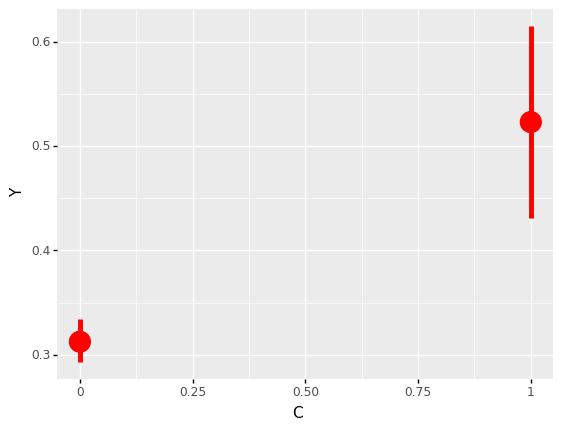

In [55]:
(ggplot(aes(x="C", y = "Y"), titanic_data) + 
 stat_summary(fun_data = "mean_cl_boot", colour = "red", size = 2)
).draw();

## Naive estimation

Let's estimate the simple observe difference
$$SOD = E[Y|D=1] - E[Y|D=0]$$

In [56]:
titanic_data.query("D == 1").Y.mean() - titanic_data.query("D == 0").Y.mean()

0.3538264720354272

## Estimation by subclassification

We will now subclassify the units into cells. 

1. We will stratify the data into four groups (young men, young women, old men, old women)
1. Calculate the difference in survival probabilities for each group.
1. Calculate the number of people in the non-first-class groups and divide by the total number of non-first-class population. These are our strata-specific weights.
1. Calculate the weighted average survival rate using the strata weights.

In [115]:
not_first_class = titanic_data.query("D==0").shape[0]

In [116]:
def weighted_avg_effect(df):
    diff = df[df.D==1].Y.mean() - df[df.D==0].Y.mean()
    weight = df[df.D==0].shape[0]/obs
    return diff*weight

In [118]:
# causal effect
titanic_data.groupby(["W", "C"]).apply(weighted_avg_effect).sum()

0.1887847327985921